# Plotting 

## Data Aggregation

In [ ]:
import os
import json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path


NUM_ITER = 1000
SCENE_NAME = "hotdog"
# WITH_OCC = True



In [2]:
# --- 1. Data Collection and Aggregation ---

# Input directory containing the JSON files
input_dir = Path('./output/1028_without_occ/for_plot/')
# Output directory for aggregated JSONs and plots
output_dir = Path('output/exp1028_plots/')
output_dir.mkdir(parents=True, exist_ok=True)

files = sorted(glob(str(input_dir / '*.json')))
# policy -> list of {num_gs, psnr, ssim, lpips}
policy_data = defaultdict(list)

print(f"Found {len(files)} files in {input_dir}")

for fp in files:
    try:
        # Extract policy and budget from filename like 'area_131072.json'
        basename = os.path.basename(fp)
        policy, budget_str = basename.rsplit('_', 1)
        num_gs = int(budget_str.split('.')[0])

        with open(fp, 'r') as f:
            data = json.load(f)
        
        # The JSON has a structure like {"key": {"metric": value, ...}}
        # We get the first value from the top-level dictionary
        metrics = list(data.values())[0]
        
        psnr = metrics.get('PSNR')
        ssim = metrics.get('SSIM')
        lpips = metrics.get('LPIPS')

        if all(v is not None for v in [psnr, ssim, lpips]):
            policy_data[policy].append({
                "policy_name": policy,
                "num_gs": num_gs,
                "psnr": float(psnr),
                "ssim": float(ssim),
                "lpips": float(lpips)
            })
        else:
            print(f"Skipping {fp}: Missing one or more metrics.")

    except Exception as e:
        print(f"Error processing {fp}: {e}")

# --- 2. Save Aggregated Data to JSON Files ---

policies = sorted(policy_data.keys())
print(f"\nFound policies: {policies}")

for policy in policies:
    # Sort data by num_gs before saving
    sorted_data = sorted(policy_data[policy], key=lambda x: x['num_gs'])
    output_json_path = output_dir / f'{policy}_aggregated.json'
    with open(output_json_path, 'w') as f:
        json.dump(sorted_data, f, indent=2)
    print(f"Saved aggregated data to {output_json_path}")
    
# example shape
example_shape = (len(policy_data[policies[0]]),)
print(f"Example shape of aggregated data for policy '{policies[0]}': {example_shape}")


Found 30 files in output/1028_without_occ/for_plot

Found policies: ['area', 'planarity', 'rand_uni']
Saved aggregated data to output/exp1028_plots/area_aggregated.json
Saved aggregated data to output/exp1028_plots/planarity_aggregated.json
Saved aggregated data to output/exp1028_plots/rand_uni_aggregated.json
Example shape of aggregated data for policy 'area': (10,)


## Line Charts

In [14]:

# 1028 experiment
WITH_OCC = False 
aggregated_json_path = Path('output/exp1028_plots/')


# 1027 experiment
# WITH_OCC = True 
# aggregated_json_path = Path('output/exp1027_plots/')


def plot_metrics(policy_data, scene_name, num_iter, output_dir, draw_log_scale=False):
    """
    Generates and saves plots for PSNR, SSIM, and LPIPS vs. Number of Gaussians.

    Args:
        policy_data (dict): A dictionary where keys are policy names and values are lists of metric records.
        scene_name (str): The name of the scene for titles.
        num_iter (int): The number of iterations for titles.
        output_dir (Path): The directory to save the plots.
        draw_log_scale (bool): Whether to use a log scale for the x-axis.
    """
    policies = sorted(policy_data.keys())
    
    metrics_to_plot = {
        "PSNR": {"unit": "dB", "label": "PSNR (Test) [dB]"},
        "SSIM": {"unit": "", "label": "SSIM (Test)"},
        "LPIPS": {"unit": "", "label": "LPIPS (Test)"}
    }
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(policies)))

    for metric_key, metric_info in metrics_to_plot.items():
        fig, ax = plt.subplots(figsize=(8, 5))
        
        for policy, color in zip(policies, colors):
            records = policy_data.get(policy, [])
            if not records:
                continue

            # Sort by num_gs to ensure lines are drawn correctly
            records.sort(key=lambda r: r['num_gs'])
            
            xs = np.array([r['num_gs'] for r in records])
            ys = np.array([r[metric_key.lower()] for r in records])
            
            # Ensure positive x values for log scale
            xs_plot = np.maximum(xs, 1)
            
            marker = 'o'
            
            ax.plot(xs_plot, ys, marker=marker, linestyle='-', linewidth=2, markersize=5, 
                    color=color, label=policy.replace('_', ' ').title())
        
        
        ax.set_ylabel(metric_info["label"])
        fig.suptitle(f'{metric_key} vs. Number of Gaussians by Policy')
        ax.set_title(f'{scene_name} | NUM_ITER={num_iter} | WITH_OCC={WITH_OCC}', fontsize='small')
        
        ax.set_xlabel('#Gaussians')
        
        if draw_log_scale:
            try:
                ax.set_xscale('log', base=2)
                ax.set_xlabel('#Gaussians (log2 scale)')
            except TypeError:
                ax.set_xscale('log', basex=2)  # Fallback for older Matplotlib
        
        ax.grid(True, which="both", ls="--", alpha=0.3)
        ax.legend(title='Policy')
        plt.tight_layout()
        
        # Save figure
        output_fig_path = output_dir / f'{metric_key.lower()}_vs_numgs_line_chart.png'
        plt.savefig(output_fig_path, dpi=200, bbox_inches='tight')
        print(f"\nFigure saved to {output_fig_path}")
        
        plt.show()


Loading aggregated data from directory: output/exp1028_plots
  Loaded data for policy 'area'
  Loaded data for policy 'planarity'
  Loaded data for policy 'rand_uni'

Figure saved to output/exp1028_plots/psnr_vs_numgs_line_chart.png


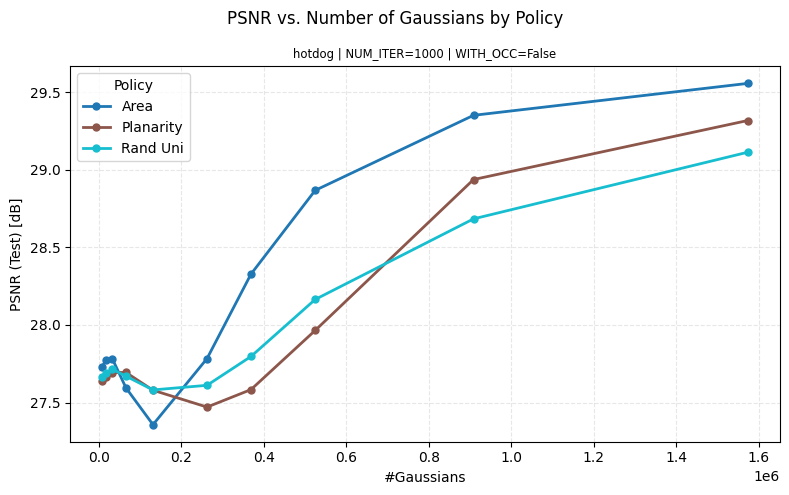


Figure saved to output/exp1028_plots/ssim_vs_numgs_line_chart.png


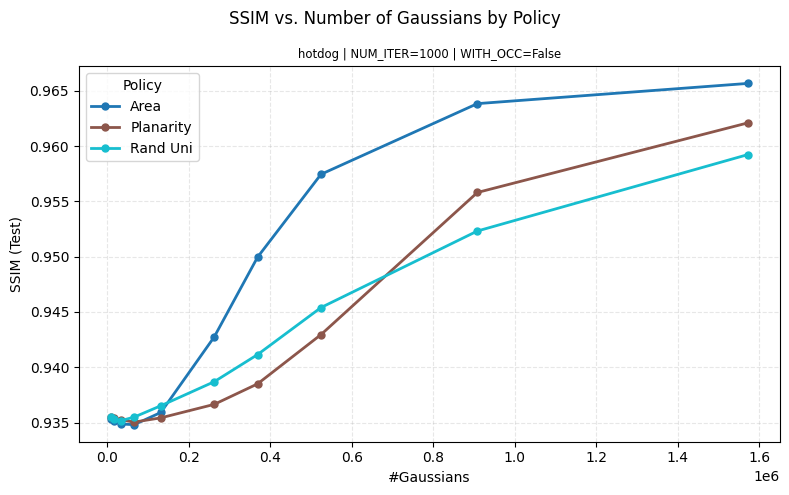


Figure saved to output/exp1028_plots/lpips_vs_numgs_line_chart.png


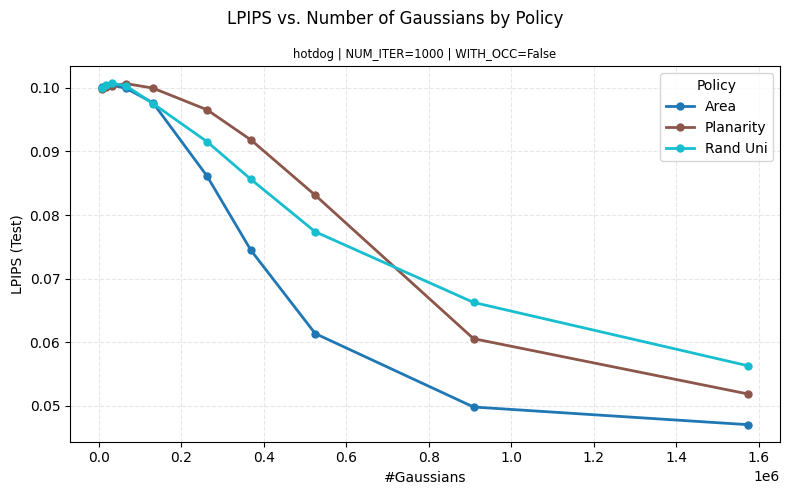

In [15]:
""" 3. Plotting """


# --- Plotting Logic ---

if aggregated_json_path and aggregated_json_path.is_dir():
    print(f"Loading aggregated data from directory: {aggregated_json_path}")
    data_to_plot = defaultdict(list)
    json_files = sorted(glob(str(aggregated_json_path / '*_aggregated.json')))
    
    if not json_files:
        print(f"No '*_aggregated.json' files found in {aggregated_json_path}")
        data_to_plot = None
    else:
        for file_path in json_files:
            try:
                policy_name = Path(file_path).name.replace('_aggregated.json', '')
                with open(file_path, 'r') as f:
                    loaded_data = json.load(f)
                
                if loaded_data:
                    data_to_plot[policy_name] = loaded_data
                    print(f"  Loaded data for policy '{policy_name}'")
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
        output_dir = aggregated_json_path

elif 'policy_data' in locals() and policy_data:
    print("Using aggregated data from the previous cell.")
    data_to_plot = policy_data

if data_to_plot:
    plot_metrics(
        policy_data=data_to_plot,
        scene_name=SCENE_NAME,
        num_iter=NUM_ITER,
        output_dir=output_dir,
        draw_log_scale=False
    )
else:
    print("\nNo data found to plot!")

## Bar Charts


In [ ]:
def plot_comparison_bars(occ_data, vanilla_data, scene_name, num_iter, output_dir, budget_idx=None):
    """
    Generates and saves bar charts comparing policies with and without OCC.
    
    Args:
        occ_data (dict): Policy data with OCC enabled.
        vanilla_data (dict): Policy data without OCC.
        scene_name (str): The name of the scene for titles.
        num_iter (int): The number of iterations for titles.
        output_dir (Path): The directory to save the plots.
        budget_idx (int): Index of the budget to compare. If None, uses the middle budget.
    """
    # Find common policies between occ and vanilla
    occ_policies = set(occ_data.keys())
    vanilla_policies = set(vanilla_data.keys())
    common_policies = sorted(occ_policies & vanilla_policies)
    
    if not common_policies:
        print("No common policies found between OCC and vanilla data!")
        return
    
    print(f"Found {len(common_policies)} common policies: {common_policies}")
    
    metrics_to_plot = {
        "PSNR": {"label": "PSNR (Test) [dB]", "higher_better": True},
        "SSIM": {"label": "SSIM (Test)", "higher_better": True},
        "LPIPS": {"label": "LPIPS (Test)", "higher_better": False}
    }
    
    # If budget_idx not specified, use middle budget
    if budget_idx is None:
        budget_idx = len(occ_data[common_policies[0]]) // 2
    
    for metric_key, metric_info in metrics_to_plot.items():
        fig, ax = plt.subplots(figsize=(12, 6))
        
        x = np.arange(len(common_policies))
        width = 0.35
        
        occ_values = []
        vanilla_values = []
        budget_label = None
        
        for policy in common_policies:
            occ_records = sorted(occ_data[policy], key=lambda r: r['num_gs'])
            vanilla_records = sorted(vanilla_data[policy], key=lambda r: r['num_gs'])
            
            # Get values at specified budget index
            if budget_idx < len(occ_records) and budget_idx < len(vanilla_records):
                occ_val = occ_records[budget_idx][metric_key.lower()]
                vanilla_val = vanilla_records[budget_idx][metric_key.lower()]
                occ_values.append(occ_val)
                vanilla_values.append(vanilla_val)
                
                if budget_label is None:
                    budget_label = f"Budget: {occ_records[budget_idx]['num_gs']:,} Gaussians"
            else:
                occ_values.append(0)
                vanilla_values.append(0)
        
        # Create bars
        bars1 = ax.bar(x - width/2, occ_values, width, label='With OCC', color='#2E86AB', alpha=0.8)
        bars2 = ax.bar(x + width/2, vanilla_values, width, label='Without OCC', color='#A23B72', alpha=0.8)
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}',
                       ha='center', va='bottom', fontsize=9)
        
        # Customize plot
        ax.set_ylabel(metric_info["label"], fontsize=12)
        ax.set_xlabel('Policy', fontsize=12)
        fig.suptitle(f'{metric_key} Comparison: With OCC vs Without OCC', fontsize=14, fontweight='bold')
        ax.set_title(f'{scene_name} | NUM_ITER={num_iter} | {budget_label}', fontsize=10)
        
        ax.set_xticks(x)
        ax.set_xticklabels([p.replace('_', ' ').title() for p in common_policies], rotation=45, ha='right')
        
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, axis='y', ls='--', alpha=0.3)
        
        plt.tight_layout()
        
        # Save figure
        output_fig_path = output_dir / f'{metric_key.lower()}_comparison_bar_chart.png'
        plt.savefig(output_fig_path, dpi=200, bbox_inches='tight')
        print(f"Figure saved to {output_fig_path}")
        
        plt.show()



from matplotlib.ticker import FuncFormatter


# [TODO] fix y-min (e.g. 26dB) across plots for policies, for better comparison
def autoset_ylim(ax, metric_key: str, values: 'list[float]') -> None:
    lo = min(values)
    hi = max(values)
    rng = max(hi - lo, 1e-9) 

    if metric_key.upper() == "PSNR":
        pad = max(0.15 * rng, 0.3)           # PSNR in dB 
        ax.set_ylim(lo - pad, hi + pad)

    elif metric_key.upper() == "SSIM":
        pad = max(0.25 * rng, 0.005)         # SSIM [0,1]
        ax.set_ylim(max(0.85, lo - pad), min(1.0, hi + pad))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.2f}"))

    elif metric_key.upper() == "LPIPS":
        pad = max(0.25 * rng, 0.01)          # LPIPS [0,1]
        ax.set_ylim(max(0.0, lo - pad), min(0.6, hi + pad))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.2f}"))


def plot_comparison_bars_all_budgets(occ_data, vanilla_data, scene_name, num_iter, output_dir):
    """
    Generates grouped bar charts showing all budgets for each policy.
    
    Args:
        occ_data (dict): Policy data with OCC enabled.
        vanilla_data (dict): Policy data without OCC.
        scene_name (str): The name of the scene for titles.
        num_iter (int): The number of iterations for titles.
        output_dir (Path): The directory to save the plotted images (.png for now).
    """
    # Find common policies
    common_policies = sorted(set(occ_data.keys()) & set(vanilla_data.keys()))
    
    if not common_policies:
        print("No common policies found!")
        return
    
    metrics_to_plot = {
        "PSNR": {"label": "PSNR (Test) [dB]"},
        "SSIM": {"label": "SSIM (Test)"},
        "LPIPS": {"label": "LPIPS (Test)"}
    }
    
    for metric_key, metric_info in metrics_to_plot.items():
        for policy in common_policies:
            fig, ax = plt.subplots(figsize=(14, 6))
            
            occ_records = sorted(occ_data[policy], key=lambda r: r['num_gs'])
            vanilla_records = sorted(vanilla_data[policy], key=lambda r: r['num_gs'])
            
            # Get common budgets
            occ_budgets = {r['num_gs']: r[metric_key.lower()] for r in occ_records}
            vanilla_budgets = {r['num_gs']: r[metric_key.lower()] for r in vanilla_records}
            common_budgets = sorted(set(occ_budgets.keys()) & set(vanilla_budgets.keys()))
            
            if not common_budgets:
                print(f"No common budgets for policy {policy}")
                continue
            
            x = np.arange(len(common_budgets))
            width = 0.35
            
            occ_vals = [occ_budgets[b] for b in common_budgets]
            vanilla_vals = [vanilla_budgets[b] for b in common_budgets]
            
            bars1 = ax.bar(x - width/2, occ_vals, width, label='With OCC', color='#2E86AB', alpha=0.8)
            bars2 = ax.bar(x + width/2, vanilla_vals, width, label='Without OCC', color='#A23B72', alpha=0.8)
            
            # Add value labels
            for bars in [bars1, bars2]:
                for bar in bars:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.2f}',
                           ha='center', va='bottom', fontsize=8, rotation=0)
            
            ax.set_ylabel(metric_info["label"], fontsize=12)
            ax.set_xlabel('#Gaussians', fontsize=12)
            fig.suptitle(f'{metric_key} Comparison: {policy.replace("_", " ").title()}', 
                        fontsize=14, fontweight='bold')
            ax.set_title(f'{scene_name} | NUM_ITER={num_iter}', fontsize=10)
            
            ax.set_xticks(x)
            ax.set_xticklabels([f'{b:,}' for b in common_budgets], rotation=45, ha='right')
            
            ax.legend(loc='best', fontsize=10)
            ax.grid(True, axis='y', ls='--', alpha=0.3)
            
            # set proper scale for y-axis
            autoset_ylim(ax, metric_key, occ_vals + vanilla_vals)
            
            plt.tight_layout()
            
            output_fig_path = output_dir / f'{metric_key.lower()}_{policy}_comparison_all_budgets_barchart.png'
            plt.savefig(output_fig_path, dpi=200, bbox_inches='tight')
            print(f"Figure saved to {output_fig_path}")
            
            plt.show()




Loaded OCC data for policy 'area'
Loaded OCC data for policy 'planarity'
Loaded OCC data for policy 'rand_uni'
Loaded vanilla data for policy 'area'
Loaded vanilla data for policy 'planarity'
Loaded vanilla data for policy 'rand_uni'

--- Plotting all budgets comparison ---
Figure saved to output/1030_comparison_plots/psnr_area_comparison_all_budgets_barchart.png


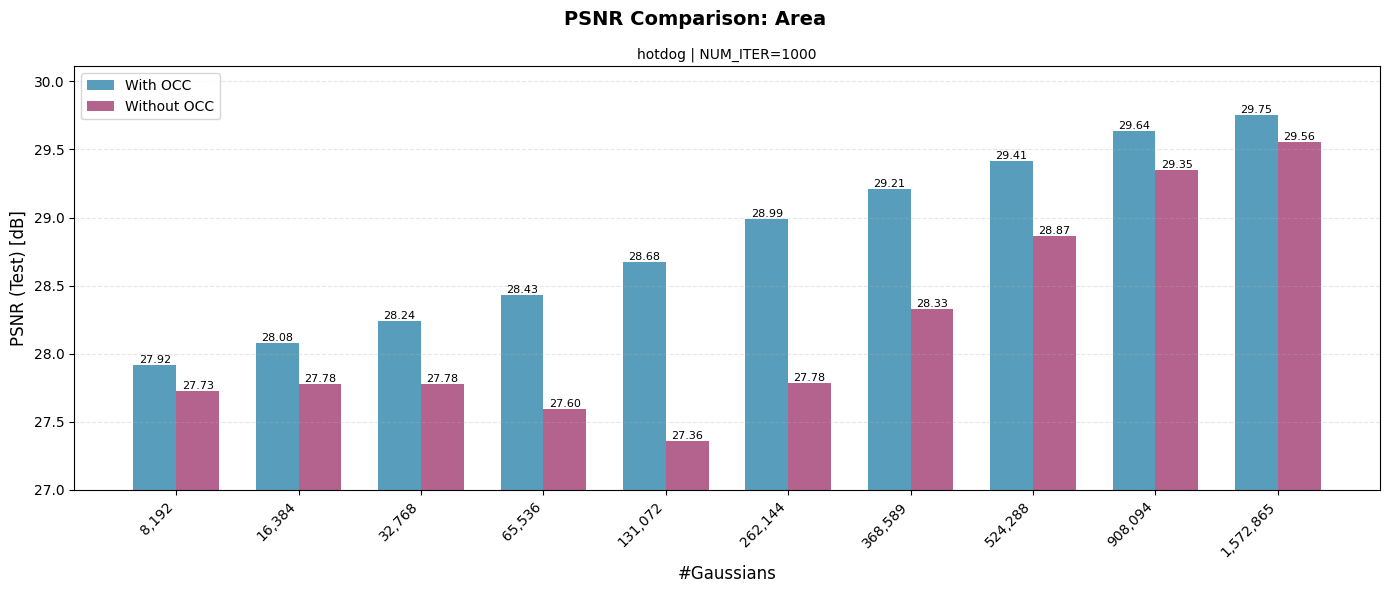

Figure saved to output/1030_comparison_plots/psnr_planarity_comparison_all_budgets_barchart.png


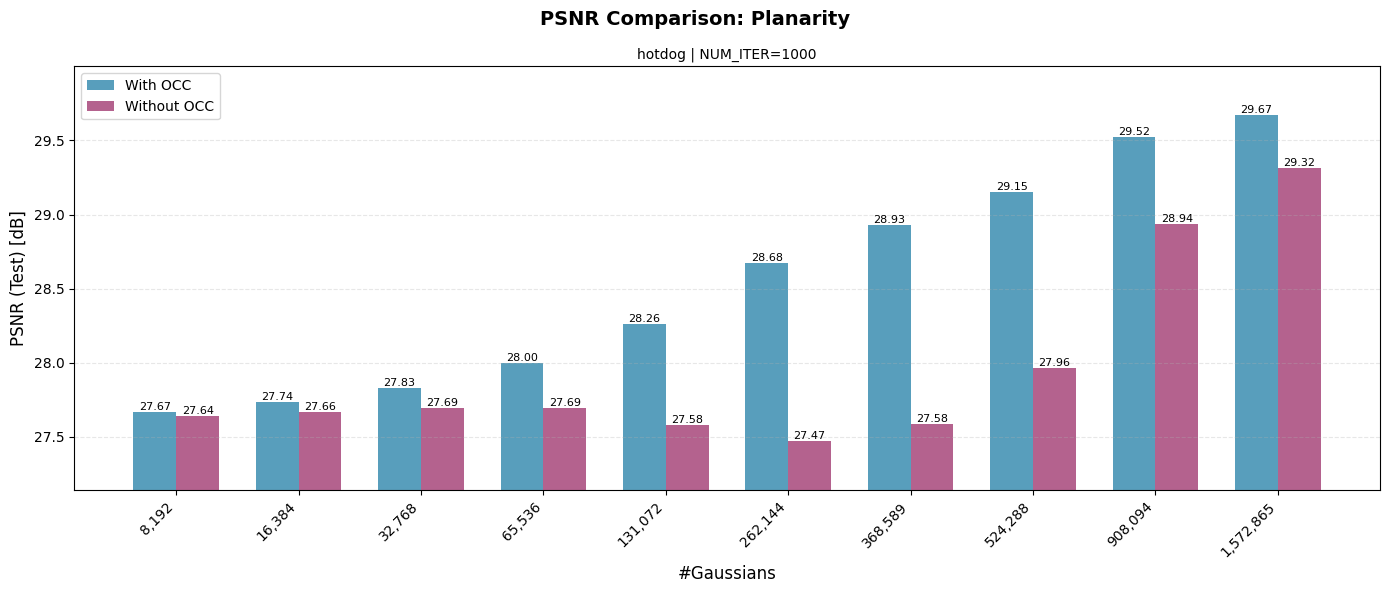

Figure saved to output/1030_comparison_plots/psnr_rand_uni_comparison_all_budgets_barchart.png


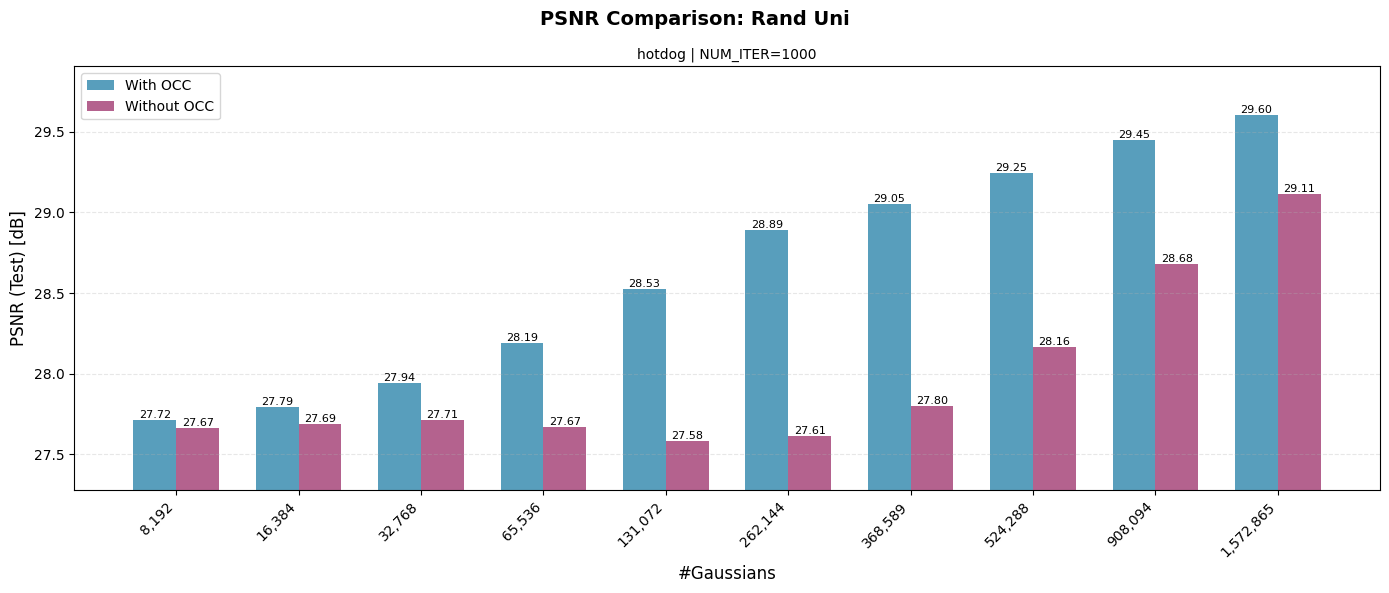

Figure saved to output/1030_comparison_plots/ssim_area_comparison_all_budgets_barchart.png


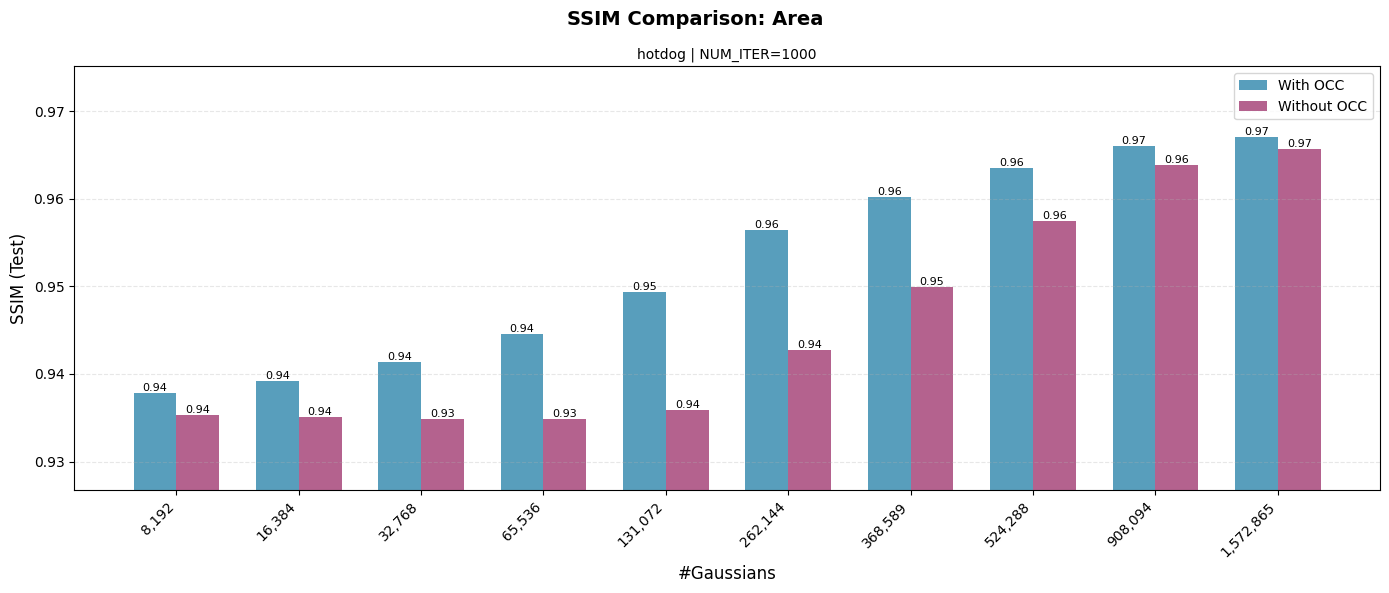

Figure saved to output/1030_comparison_plots/ssim_planarity_comparison_all_budgets_barchart.png


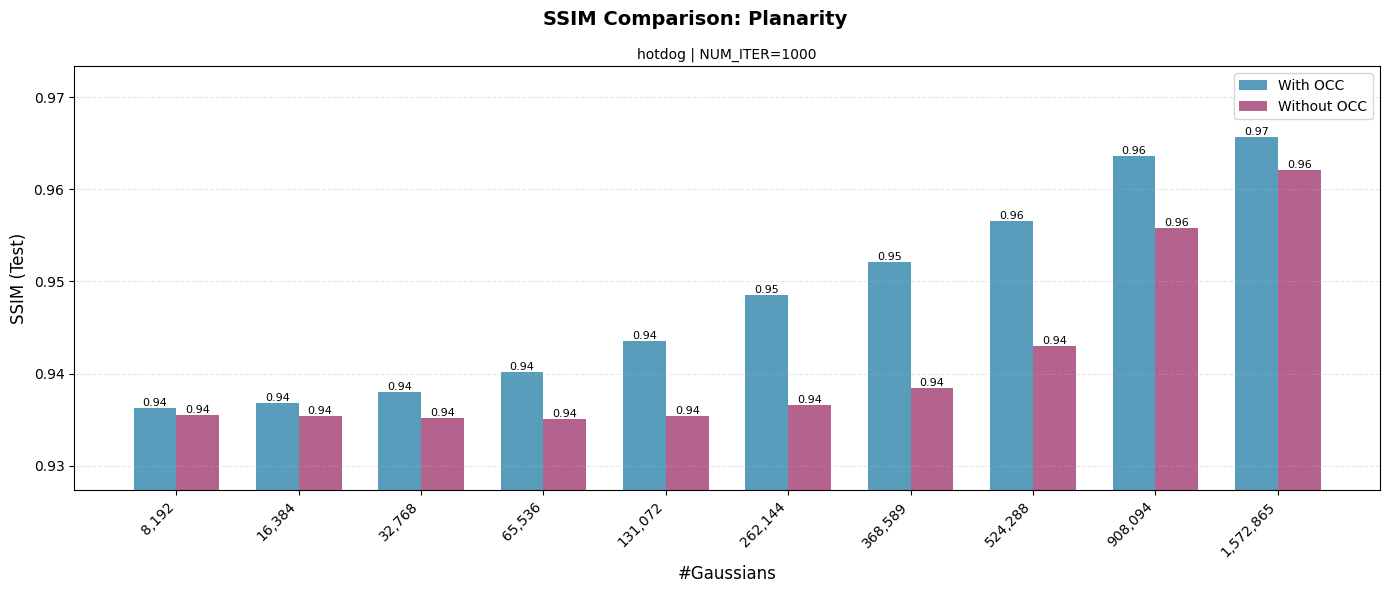

Figure saved to output/1030_comparison_plots/ssim_rand_uni_comparison_all_budgets_barchart.png


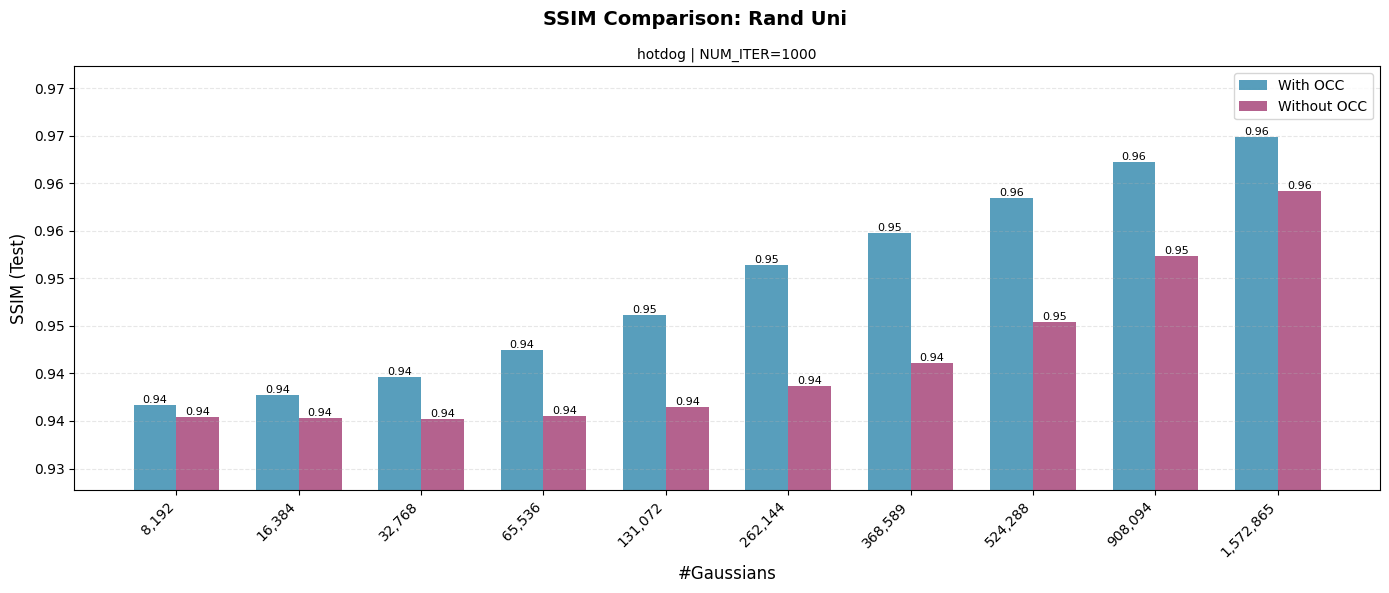

Figure saved to output/1030_comparison_plots/lpips_area_comparison_all_budgets_barchart.png


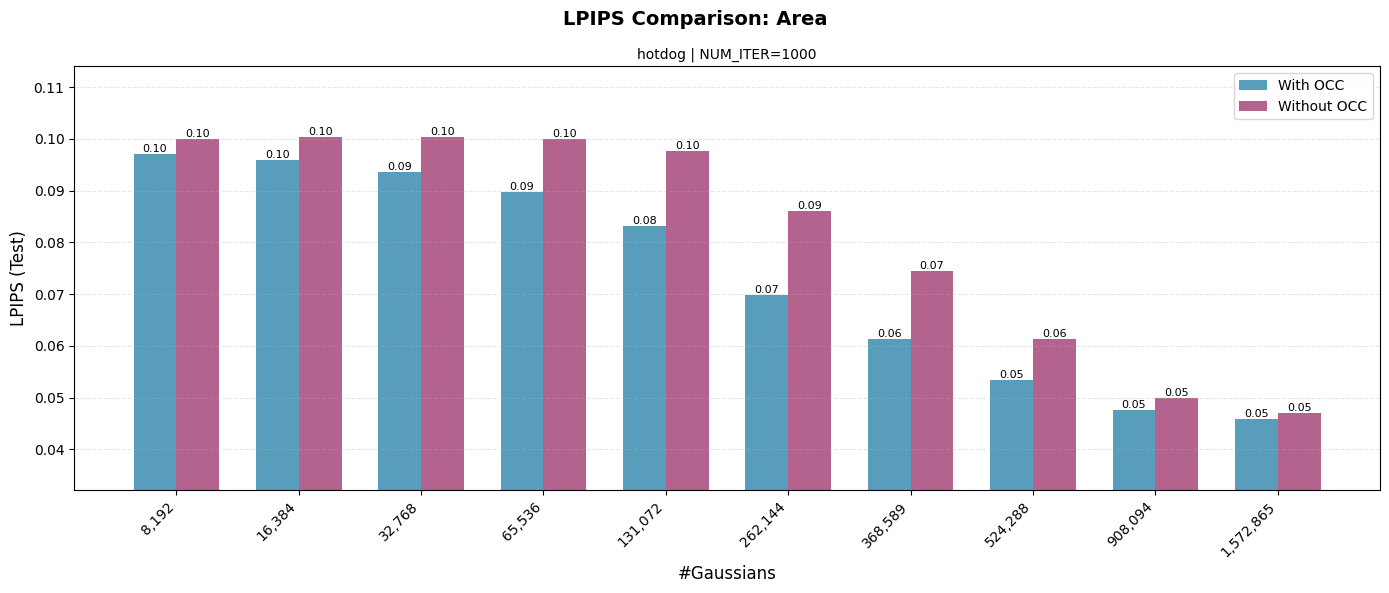

Figure saved to output/1030_comparison_plots/lpips_planarity_comparison_all_budgets_barchart.png


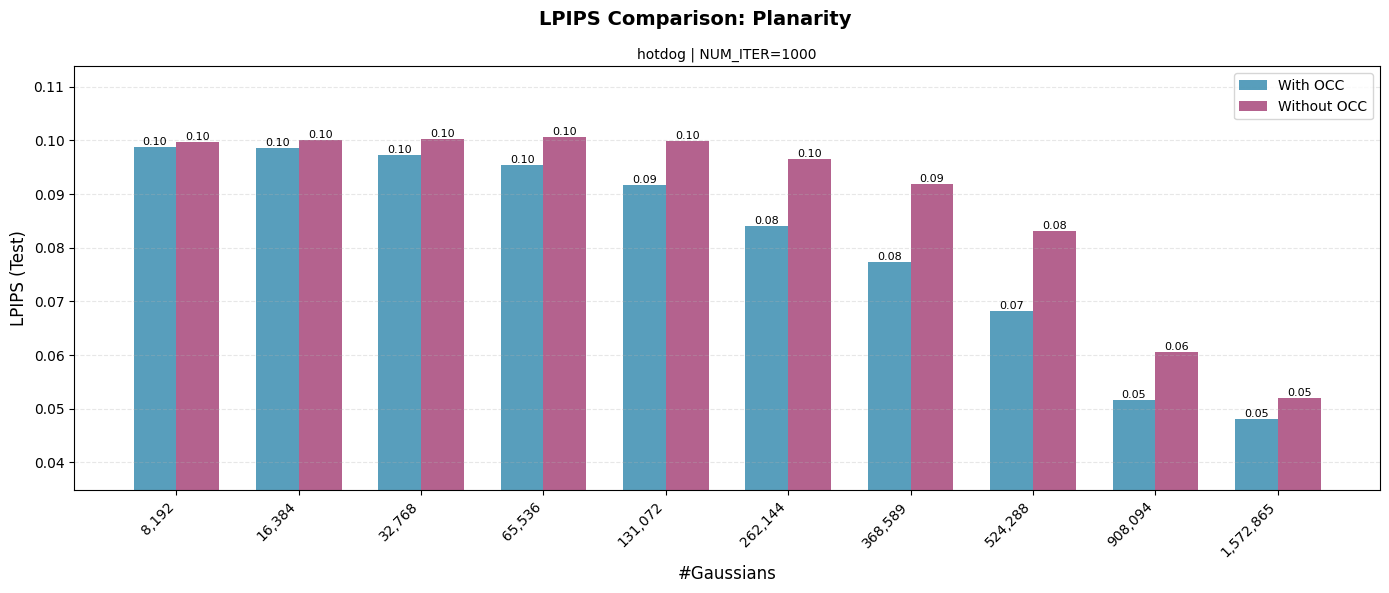

Figure saved to output/1030_comparison_plots/lpips_rand_uni_comparison_all_budgets_barchart.png


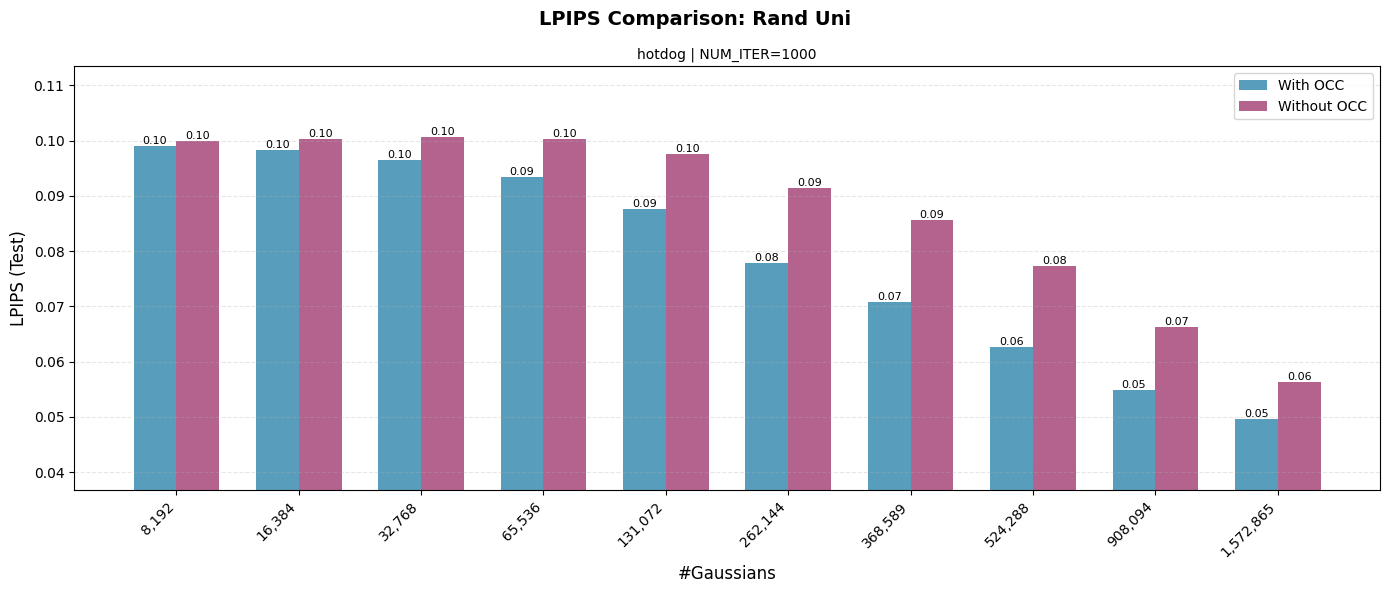

In [28]:


occ_json_path = Path('output/exp1027_plots/')
vanila_json_path = Path('output/exp1028_plots/')

""" Load data and plot comparisons """

# Load OCC data
occ_data_dict = defaultdict(list)
occ_json_files = sorted(glob(str(occ_json_path / '*_aggregated.json')))
for file_path in occ_json_files:
    policy_name = Path(file_path).name.replace('_aggregated.json', '')
    with open(file_path, 'r') as f:
        occ_data_dict[policy_name] = json.load(f)
    print(f"Loaded OCC data for policy '{policy_name}'")

# Load vanilla data
vanilla_data_dict = defaultdict(list)
vanilla_json_files = sorted(glob(str(vanila_json_path / '*_aggregated.json')))
for file_path in vanilla_json_files:
    policy_name = Path(file_path).name.replace('_aggregated.json', '')
    with open(file_path, 'r') as f:
        vanilla_data_dict[policy_name] = json.load(f)
    print(f"Loaded vanilla data for policy '{policy_name}'")

# Create output directory for comparison plots
comparison_output_dir = Path('output/1030_comparison_plots/')
comparison_output_dir.mkdir(parents=True, exist_ok=True)

# Plot comparison for a specific budget (middle budget by default)
# print("\n--- Plotting single budget comparison ---")
# plot_comparison_bars(
#     occ_data=occ_data_dict,
#     vanilla_data=vanilla_data_dict,
#     scene_name=SCENE_NAME,
#     num_iter=NUM_ITER,
#     output_dir=comparison_output_dir,
#     budget_idx=None  # Use middle budget, or specify an index
# )

# Plot comparison for all budgets (one plot per policy)
print("\n--- Plotting all budgets comparison ---")
plot_comparison_bars_all_budgets(
    occ_data=occ_data_dict,
    vanilla_data=vanilla_data_dict,
    scene_name=SCENE_NAME,
    num_iter=NUM_ITER,
    output_dir=comparison_output_dir
)




# Entropy Image

In [14]:
from skimage import io, color
from skimage.filters import rank
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np

# load image and convert to grayscale, 8-bit
img = io.imread("data/dynerf/test_yc_mesh/mesh_000.png")

# Check if the image has an alpha channel (4 channels) and remove it if present
if img.shape[-1] == 4:
    img = img[..., :3]

gray = color.rgb2gray(img)
gray_ubyte = (gray * 255).astype(np.uint8)

# compute local entropy with a disk-shaped neighborhood
entropy_img = rank.entropy(gray_ubyte, disk(5))
# disk() value can be adjusted

# overall complexity score = mean entropy
complexity = np.mean(entropy_img)
print("Spatial complexity (entropy):", complexity)

# show result
plt.imshow(entropy_img, cmap="magma")
plt.colorbar()
plt.show()

ModuleNotFoundError: No module named 'skimage'